<a href="https://colab.research.google.com/github/ekvirika/WalmartRecruiting/blob/main/notebooks/model_experiment_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn mlflow

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 46.9MB/s]


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


Training data shape: (421570, 17)
Test data shape: (115064, 16)
=== Data Exploration ===
Training period: 2010-02-05 to 2012-10-26
Number of stores: 45
Number of departments: 81
Missing values in Weekly_Sales: 0


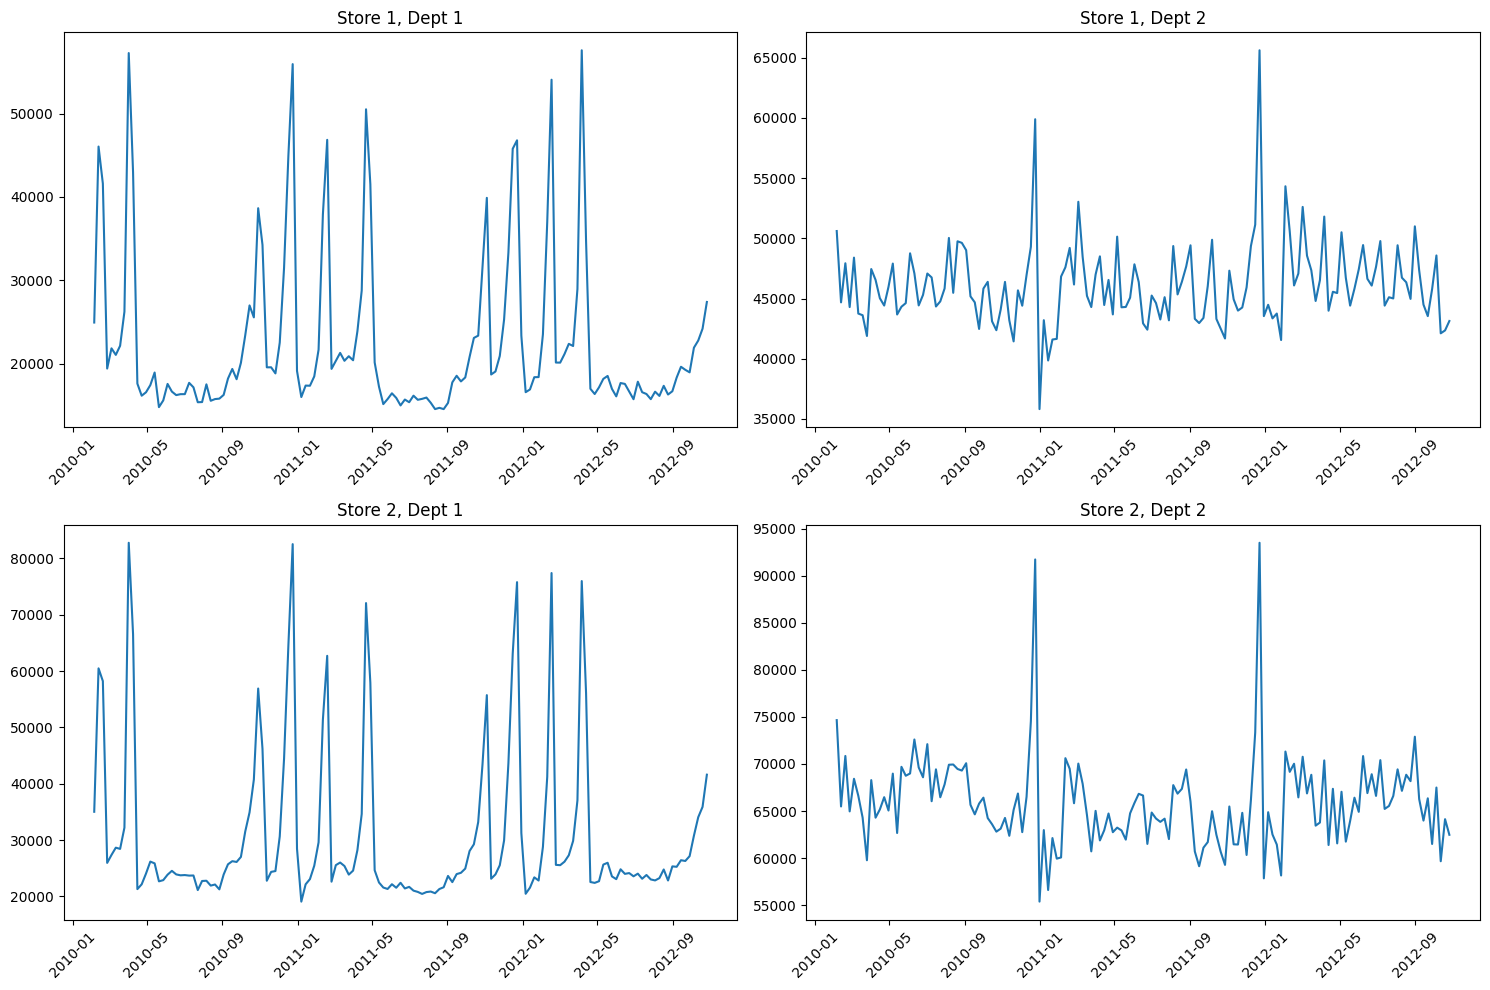


=== Sales Statistics ===
count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64
Training set size: 335900
Validation set size: 85670
=== Training ARIMA Models ===


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Time series specific libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ML libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature

# Other utilities
import pickle
import os
from datetime import datetime, timedelta
import itertools
from typing import Tuple, List, Dict, Optional
import joblib

class WalmartDataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Custom preprocessor for Walmart sales data.
    Handles missing values, creates time-based features, and prepares data for ARIMA modeling.
    """

    def __init__(self,
                 date_column: str = 'Date',
                 sales_column: str = 'Weekly_Sales',
                 store_column: str = 'Store',
                 dept_column: str = 'Dept',
                 fill_method: str = 'forward'):
        """
        Initialize the preprocessor.

        Args:
            date_column: Name of the date column
            sales_column: Name of the sales column to forecast
            store_column: Name of the store identifier column
            dept_column: Name of the department identifier column
            fill_method: Method for handling missing values ('forward', 'backward', 'mean')
        """
        self.date_column = date_column
        self.sales_column = sales_column
        self.store_column = store_column
        self.dept_column = dept_column
        self.fill_method = fill_method
        self.scalers = {}
        self.holiday_dates = []

    def fit(self, X, y=None):
        """Fit the preprocessor to the training data."""
        # Store unique stores and departments
        self.stores = X[self.store_column].unique()
        self.departments = X[self.dept_column].unique()

        # Identify holiday dates (when IsHoliday is True)
        if 'IsHoliday' in X.columns:
            self.holiday_dates = X[X['IsHoliday'] == True][self.date_column].unique()

        # Fit scalers for each store-department combination
        for store in self.stores:
            for dept in self.departments:
                key = f"{store}_{dept}"
                mask = (X[self.store_column] == store) & (X[self.dept_column] == dept)
                store_dept_data = X[mask]

                if len(store_dept_data) > 0:
                    scaler = StandardScaler()
                    sales_data = store_dept_data[self.sales_column].values.reshape(-1, 1)
                    # Handle missing values before fitting scaler
                    sales_data_clean = sales_data[~np.isnan(sales_data.flatten())]
                    if len(sales_data_clean) > 0:
                        scaler.fit(sales_data_clean.reshape(-1, 1))
                        self.scalers[key] = scaler

        return self

    def transform(self, X):
        """Transform the input data."""
        X_transformed = X.copy()

        # Convert date column to datetime
        X_transformed[self.date_column] = pd.to_datetime(X_transformed[self.date_column])

        # Sort by date
        X_transformed = X_transformed.sort_values([self.store_column, self.dept_column, self.date_column])

        # Create time-based features
        X_transformed['Year'] = X_transformed[self.date_column].dt.year
        X_transformed['Month'] = X_transformed[self.date_column].dt.month
        X_transformed['Week'] = X_transformed[self.date_column].dt.isocalendar().week
        X_transformed['DayOfYear'] = X_transformed[self.date_column].dt.dayofyear
        X_transformed['Quarter'] = X_transformed[self.date_column].dt.quarter

        # Create cyclical features for seasonality
        X_transformed['Month_sin'] = np.sin(2 * np.pi * X_transformed['Month'] / 12)
        X_transformed['Month_cos'] = np.cos(2 * np.pi * X_transformed['Month'] / 12)
        X_transformed['Week_sin'] = np.sin(2 * np.pi * X_transformed['Week'] / 52)
        X_transformed['Week_cos'] = np.cos(2 * np.pi * X_transformed['Week'] / 52)

        # Handle missing values in sales data
        X_transformed = self._handle_missing_values(X_transformed)

        return X_transformed

    def _handle_missing_values(self, df):
        """Handle missing values in the sales data."""
        df_filled = df.copy()

        for store in self.stores:
            for dept in self.departments:
                mask = (df_filled[self.store_column] == store) & (df_filled[self.dept_column] == dept)
                store_dept_data = df_filled[mask]

                if len(store_dept_data) > 0:
                    if self.fill_method == 'forward':
                        df_filled.loc[mask, self.sales_column] = store_dept_data[self.sales_column].fillna(method='ffill')
                    elif self.fill_method == 'backward':
                        df_filled.loc[mask, self.sales_column] = store_dept_data[self.sales_column].fillna(method='bfill')
                    elif self.fill_method == 'mean':
                        mean_sales = store_dept_data[self.sales_column].mean()
                        df_filled.loc[mask, self.sales_column] = store_dept_data[self.sales_column].fillna(mean_sales)

        return df_filled

class ARIMATimeSeriesModel(BaseEstimator):
    """
    ARIMA model wrapper for time series forecasting.
    Handles automatic order selection and fitting for multiple time series.
    """

    def __init__(self,
                 order: Optional[Tuple[int, int, int]] = None,
                 seasonal_order: Optional[Tuple[int, int, int, int]] = None,
                 auto_arima: bool = True,
                 max_p: int = 5,
                 max_d: int = 2,
                 max_q: int = 5,
                 seasonal: bool = True,
                 m: int = 52):  # 52 weeks in a year
        """
        Initialize ARIMA model.

        Args:
            order: ARIMA order (p, d, q) if not using auto_arima
            seasonal_order: Seasonal ARIMA order (P, D, Q, s) if not using auto_arima
            auto_arima: Whether to automatically select best ARIMA parameters
            max_p, max_d, max_q: Maximum values for auto ARIMA parameter search
            seasonal: Whether to include seasonal components
            m: Seasonal period (52 for weekly data)
        """
        self.order = order
        self.seasonal_order = seasonal_order
        self.auto_arima = auto_arima
        self.max_p = max_p
        self.max_d = max_d
        self.max_q = max_q
        self.seasonal = seasonal
        self.m = m
        self.models = {}
        self.best_orders = {}

    def _check_stationarity(self, series: pd.Series) -> Dict[str, float]:
        """
        Check if a time series is stationary using ADF and KPSS tests.

        Args:
            series: Time series data

        Returns:
            Dictionary with test results
        """
        # Remove NaN values
        series_clean = series.dropna()

        # Augmented Dickey-Fuller test
        adf_result = adfuller(series_clean)
        adf_statistic = adf_result[0]
        adf_p_value = adf_result[1]

        # KPSS test
        kpss_result = kpss(series_clean)
        kpss_statistic = kpss_result[0]
        kpss_p_value = kpss_result[1]

        return {
            'adf_statistic': adf_statistic,
            'adf_p_value': adf_p_value,
            'kpss_statistic': kpss_statistic,
            'kpss_p_value': kpss_p_value,
            'is_stationary': adf_p_value < 0.05 and kpss_p_value > 0.05
        }

    def _find_best_arima_order(self, series: pd.Series) -> Tuple[int, int, int]:
        """
        Find the best ARIMA order using grid search with AIC criterion.

        Args:
            series: Time series data

        Returns:
            Best ARIMA order (p, d, q)
        """
        best_aic = float('inf')
        best_order = (0, 0, 0)

        # Remove NaN values
        series_clean = series.dropna()

        if len(series_clean) < 10:  # Need minimum data points
            return (1, 1, 1)

        # Grid search for best parameters
        for p in range(self.max_p + 1):
            for d in range(self.max_d + 1):
                for q in range(self.max_q + 1):
                    try:
                        if self.seasonal:
                            # For seasonal ARIMA
                            model = ARIMA(series_clean, order=(p, d, q),
                                        seasonal_order=(1, 1, 1, self.m))
                        else:
                            # For non-seasonal ARIMA
                            model = ARIMA(series_clean, order=(p, d, q))

                        fitted_model = model.fit()
                        aic = fitted_model.aic

                        if aic < best_aic:
                            best_aic = aic
                            best_order = (p, d, q)
                    except:
                        continue

        return best_order

    def fit(self, X, y=None):
        """
        Fit ARIMA models for each store-department combination.

        Args:
            X: Input data with time series
            y: Not used (for compatibility)
        """
        # Group by store and department
        groups = X.groupby(['Store', 'Dept'])

        for (store, dept), group_data in groups:
            key = f"{store}_{dept}"

            # Sort by date
            group_data = group_data.sort_values('Date')

            # Extract sales time series
            sales_series = group_data['Weekly_Sales']

            # Skip if insufficient data
            if len(sales_series) < 10:
                continue

            # Check stationarity
            stationarity_test = self._check_stationarity(sales_series)

            try:
                if self.auto_arima:
                    # Find best ARIMA order
                    best_order = self._find_best_arima_order(sales_series)
                    self.best_orders[key] = best_order

                    if self.seasonal:
                        # Fit seasonal ARIMA
                        model = ARIMA(sales_series, order=best_order,
                                    seasonal_order=(1, 1, 1, self.m))
                    else:
                        # Fit non-seasonal ARIMA
                        model = ARIMA(sales_series, order=best_order)
                else:
                    # Use predefined order
                    if self.seasonal and self.seasonal_order:
                        model = ARIMA(sales_series, order=self.order,
                                    seasonal_order=self.seasonal_order)
                    else:
                        model = ARIMA(sales_series, order=self.order)

                # Fit the model
                fitted_model = model.fit()
                self.models[key] = fitted_model

            except Exception as e:
                print(f"Failed to fit ARIMA for Store {store}, Dept {dept}: {e}")
                continue

        return self

    def predict(self, X):
        """
        Make predictions for the test set.

        Args:
            X: Test data

        Returns:
            Predictions array
        """
        predictions = []

        for idx, row in X.iterrows():
            store = row['Store']
            dept = row['Dept']
            key = f"{store}_{dept}"

            if key in self.models:
                try:
                    # Make prediction for one step ahead
                    forecast = self.models[key].forecast(steps=1)
                    predictions.append(forecast[0])
                except:
                    # If prediction fails, use last known value or mean
                    predictions.append(0)  # Default fallback
            else:
                predictions.append(0)  # Default for unseen store-dept combinations

        return np.array(predictions)

    def get_model_summary(self, store: int, dept: int) -> str:
        """Get summary of fitted model for specific store-department combination."""
        key = f"{store}_{dept}"
        if key in self.models:
            return str(self.models[key].summary())
        else:
            return f"No model found for Store {store}, Dept {dept}"

class ARIMAPipeline:
    """
    Complete ARIMA pipeline for Walmart sales forecasting.
    Combines preprocessing, modeling, and evaluation.
    """

    def __init__(self,
                 auto_arima: bool = True,
                 seasonal: bool = True,
                 test_size: float = 0.2):
        """
        Initialize the ARIMA pipeline.

        Args:
            auto_arima: Whether to use automatic ARIMA parameter selection
            seasonal: Whether to include seasonal components
            test_size: Fraction of data to use for testing
        """
        self.auto_arima = auto_arima
        self.seasonal = seasonal
        self.test_size = test_size

        # Initialize components
        self.preprocessor = WalmartDataPreprocessor()
        self.model = ARIMATimeSeriesModel(auto_arima=auto_arima, seasonal=seasonal)

        # Create scikit-learn pipeline
        self.pipeline = Pipeline([
            ('preprocessor', self.preprocessor),
            ('model', self.model)
        ])

        self.is_fitted = False
        self.train_metrics = {}
        self.test_metrics = {}

    def load_data(self, train_path: str, test_path: str, stores_path: str = None, features_path: str = None):
        """
        Load Walmart dataset from CSV files.

        Args:
            train_path: Path to training data CSV
            test_path: Path to test data CSV
            stores_path: Path to stores data CSV (optional)
            features_path: Path to features data CSV (optional)
        """
        # Load main datasets
        self.train_data = pd.read_csv(train_path)
        self.test_data = pd.read_csv(test_path)

        # Load additional datasets if provided
        if stores_path:
            self.stores_data = pd.read_csv(stores_path)
            # Merge stores data
            self.train_data = self.train_data.merge(self.stores_data, on='Store', how='left')
            self.test_data = self.test_data.merge(self.stores_data, on='Store', how='left')

        if features_path:
            self.features_data = pd.read_csv(features_path)
            # Merge features data
            self.train_data = self.train_data.merge(self.features_data, on=['Store', 'Date'], how='left')
            self.test_data = self.test_data.merge(self.features_data, on=['Store', 'Date'], how='left')

        print(f"Training data shape: {self.train_data.shape}")
        print(f"Test data shape: {self.test_data.shape}")

        return self

    def explore_data(self):
        """Perform exploratory data analysis."""
        print("=== Data Exploration ===")
        print(f"Training period: {self.train_data['Date'].min()} to {self.train_data['Date'].max()}")
        print(f"Number of stores: {self.train_data['Store'].nunique()}")
        print(f"Number of departments: {self.train_data['Dept'].nunique()}")
        print(f"Missing values in Weekly_Sales: {self.train_data['Weekly_Sales'].isna().sum()}")

        # Plot some sample time series
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Plot sales for a few store-department combinations
        sample_stores = self.train_data['Store'].unique()[:2]
        sample_depts = self.train_data['Dept'].unique()[:2]

        for i, store in enumerate(sample_stores):
            for j, dept in enumerate(sample_depts):
                mask = (self.train_data['Store'] == store) & (self.train_data['Dept'] == dept)
                store_dept_data = self.train_data[mask].copy()

                if len(store_dept_data) > 0:
                    store_dept_data['Date'] = pd.to_datetime(store_dept_data['Date'])
                    store_dept_data = store_dept_data.sort_values('Date')

                    axes[i, j].plot(store_dept_data['Date'], store_dept_data['Weekly_Sales'])
                    axes[i, j].set_title(f'Store {store}, Dept {dept}')
                    axes[i, j].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

        # Show basic statistics
        print("\n=== Sales Statistics ===")
        print(self.train_data['Weekly_Sales'].describe())

        return self

    def train_test_split(self):
        """Split data into training and validation sets."""
        # Sort by date
        self.train_data['Date'] = pd.to_datetime(self.train_data['Date'])
        self.train_data = self.train_data.sort_values(['Store', 'Dept', 'Date'])

        # Split by time for each store-department combination
        train_list = []
        val_list = []

        for (store, dept), group in self.train_data.groupby(['Store', 'Dept']):
            group = group.sort_values('Date')
            split_idx = int(len(group) * (1 - self.test_size))

            train_part = group.iloc[:split_idx]
            val_part = group.iloc[split_idx:]

            train_list.append(train_part)
            val_list.append(val_part)

        self.X_train = pd.concat(train_list, ignore_index=True)
        self.X_val = pd.concat(val_list, ignore_index=True)

        print(f"Training set size: {len(self.X_train)}")
        print(f"Validation set size: {len(self.X_val)}")

        return self

    def fit(self):
        """Fit the ARIMA pipeline."""
        print("=== Training ARIMA Models ===")

        # Fit the pipeline
        self.pipeline.fit(self.X_train)
        self.is_fitted = True

        # Make predictions on training set
        train_predictions = self.pipeline.predict(self.X_train)

        # Calculate training metrics
        train_actual = self.X_train['Weekly_Sales'].values
        self.train_metrics = {
            'MAE': mean_absolute_error(train_actual, train_predictions),
            'RMSE': np.sqrt(mean_squared_error(train_actual, train_predictions)),
            'MAPE': np.mean(np.abs((train_actual - train_predictions) / train_actual)) * 100
        }

        print(f"Training MAE: {self.train_metrics['MAE']:.2f}")
        print(f"Training RMSE: {self.train_metrics['RMSE']:.2f}")
        print(f"Training MAPE: {self.train_metrics['MAPE']:.2f}%")

        return self

    def evaluate(self):
        """Evaluate the model on validation set."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before evaluation")

        print("=== Evaluating on Validation Set ===")

        # Make predictions on validation set
        val_predictions = self.pipeline.predict(self.X_val)

        # Calculate validation metrics
        val_actual = self.X_val['Weekly_Sales'].values
        self.test_metrics = {
            'MAE': mean_absolute_error(val_actual, val_predictions),
            'RMSE': np.sqrt(mean_squared_error(val_actual, val_predictions)),
            'MAPE': np.mean(np.abs((val_actual - val_predictions) / val_actual)) * 100
        }

        print(f"Validation MAE: {self.test_metrics['MAE']:.2f}")
        print(f"Validation RMSE: {self.test_metrics['RMSE']:.2f}")
        print(f"Validation MAPE: {self.test_metrics['MAPE']:.2f}%")

        # Plot some predictions vs actual
        self._plot_predictions(val_actual, val_predictions)

        return self

    def _plot_predictions(self, actual, predictions, n_samples=4):
        """Plot predictions vs actual values for sample store-department combinations."""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        # Get unique store-department combinations
        store_dept_combinations = self.X_val[['Store', 'Dept']].drop_duplicates().head(n_samples)

        for i, (_, row) in enumerate(store_dept_combinations.iterrows()):
            if i >= n_samples:
                break

            store, dept = row['Store'], row['Dept']
            mask = (self.X_val['Store'] == store) & (self.X_val['Dept'] == dept)

            store_dept_data = self.X_val[mask].copy()
            store_dept_actual = actual[mask]
            store_dept_pred = predictions[mask]

            if len(store_dept_data) > 0:
                store_dept_data['Date'] = pd.to_datetime(store_dept_data['Date'])
                store_dept_data = store_dept_data.sort_values('Date')

                axes[i].plot(store_dept_data['Date'], store_dept_actual, label='Actual', marker='o')
                axes[i].plot(store_dept_data['Date'], store_dept_pred, label='Predicted', marker='s')
                axes[i].set_title(f'Store {store}, Dept {dept}')
                axes[i].legend()
                axes[i].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def predict_test(self):
        """Make predictions on the test set."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        print("=== Making Test Predictions ===")

        # Make predictions
        test_predictions = self.pipeline.predict(self.test_data)

        # Create submission dataframe
        submission = pd.DataFrame({
            'Id': self.test_data['Id'],
            'Weekly_Sales': test_predictions
        })

        return submission

    def save_model(self, model_path: str):
        """Save the trained pipeline."""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before saving")

        joblib.dump(self.pipeline, model_path)
        print(f"Model saved to {model_path}")

    def load_model(self, model_path: str):
        """Load a pre-trained pipeline."""
        self.pipeline = joblib.load(model_path)
        self.is_fitted = True
        print(f"Model loaded from {model_path}")

        return self

# MLflow experiment tracking functions
def log_arima_experiment(pipeline: ARIMAPipeline, experiment_name: str = "ARIMA_Training"):
    """Log ARIMA experiment to MLflow."""

    # Set or create experiment
    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name="ARIMA_Training"):
        # Log parameters
        mlflow.log_param("auto_arima", pipeline.auto_arima)
        mlflow.log_param("seasonal", pipeline.seasonal)
        mlflow.log_param("test_size", pipeline.test_size)

        # Log metrics
        if pipeline.train_metrics:
            for metric, value in pipeline.train_metrics.items():
                mlflow.log_metric(f"train_{metric.lower()}", value)

        if pipeline.test_metrics:
            for metric, value in pipeline.test_metrics.items():
                mlflow.log_metric(f"val_{metric.lower()}", value)

        # Log model
        mlflow.sklearn.log_model(
            pipeline.pipeline,
            "arima_model",
            registered_model_name="WalmartSales_ARIMA"
        )

        print("Experiment logged to MLflow successfully!")

# Example usage function
def run_arima_pipeline():
    """Example function showing how to use the ARIMA pipeline."""

    # Initialize pipeline
    pipeline = ARIMAPipeline(
        auto_arima=True,
        seasonal=True,
        test_size=0.2
    )

    # Load data (you need to provide actual file paths)
    pipeline.load_data(
        train_path='train.csv',
        test_path='test.csv',
        stores_path='stores.csv',
        features_path='features.csv'
    )

    # Explore data
    pipeline.explore_data()

    # Split data
    pipeline.train_test_split()

    # Train model
    pipeline.fit()

    # Evaluate model
    pipeline.evaluate()

    # Make test predictions
    submission = pipeline.predict_test()
    submission.to_csv('arima_submission.csv', index=False)

    # Save model
    pipeline.save_model('arima_model.joblib')

    # Log to MLflow
    log_arima_experiment(pipeline, "ARIMA_Experiments")

    print("ARIMA pipeline completed successfully!")

if __name__ == "__main__":
    # Run the pipeline
    run_arima_pipeline()